# Please find below the high-level structuring of python scripts in the attached folder. 

## Feature Engineering Script: 
* Feature Engineering_PPM  --- PPM, PRNR, Premium Freight

## Individual Model Scripts:
* regression approach PPM-v3
* regression approach prem freight 
* regression approach prnr
* Vulnerability Score Reg ----contains the feature engineering piece of vulnerability score as well

## Prod Scripts:
* Prod Script_V1   --- PPM, PRNR, Premium Freight
* Prod Script Vulnerability Score  ----- Vulnerability Score

## We need to run the prod scripts in the 1st week of every month

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error 
from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.chdir(r"C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\Supplier_Risk")

### Read datasets

In [2]:
df=pd.read_csv(os.getcwd()+r"\data\features_file.csv")

In [3]:
df[['PRNR', 'PREM FREIGHT']] = df[['PRNR', 'PREM FREIGHT']].fillna(0)

In [4]:
df["PRNR_TARGET"] = np.where(df["PRNR"]>=3,1,0)
df["PREM_FREIGHT_TARGET"] = np.where(df["PREM FREIGHT"]>=3,1,0)

In [5]:
df["MONTH"] = pd.to_datetime(df["MONTH"], format = "%Y-%m-%d")

In [6]:
df.head()

,VENDOR_NAME,MONTH,PRNR,PREM FREIGHT,PPM Flag,QTY_RECD_FLAG_mean_MOM_1,Qty Ordered_sum_MOM_1,Qty Recd_sum_MOM_1,PRNR_sum_MOM_1,PREM FREIGHT_sum_MOM_1,...,PPM Qty Rejected_sum_OQT_10,PPM Qty Shipped_max_OQT_10,PPM Qty Shipped_min_OQT_10,PPM Qty Shipped_std_OQT_10,PPM Qty Shipped_mean_OQT_10,PPM Qty Shipped_sum_OQT_10,PPM_Agg_Flag_OQT_10,Qty Recd_percent_Agg_OQT_10,PRNR_TARGET,PREM_FREIGHT_TARGET
0,*CERATIZIT CHICAGO INC,2022-01-01,0.0,0.0,NaN,NaN,0.0,3.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,0
1,*KAMAX LP,2022-01-01,0.0,0.0,NaN,1.0,496800.0,574000.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,90.740741,0,0
2,2A MATERIAIS ELETRICOS LTDA,2022-01-01,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,3 DIMENSIONAL SERVICES,2022-01-01,0.0,0.0,NaN,NaN,0.0,115.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,0
4,A & F GROBSERIEN GMBH,2022-01-01,0.0,0.0,0.0,1.0,14364.0,28164.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,98.726223,0,0


In [7]:
PREM_FREIGHT_cols = list(df)
PREM_FREIGHT_cols

['VENDOR_NAME',
 'MONTH',
 'PRNR',
 'PREM FREIGHT',
 'PPM Flag',
 'QTY_RECD_FLAG_mean_MOM_1',
 'Qty Ordered_sum_MOM_1',
 'Qty Recd_sum_MOM_1',
 'PRNR_sum_MOM_1',
 'PREM FREIGHT_sum_MOM_1',
 'Cost Recovery_sum_MOM_1',
 'PPM Qty Rejected_sum_MOM_1',
 'PPM Qty Shipped_sum_MOM_1',
 'QTY_RECD_FLAG_mean_MOM_2',
 'Qty Ordered_sum_MOM_2',
 'Qty Recd_sum_MOM_2',
 'PRNR_sum_MOM_2',
 'PREM FREIGHT_sum_MOM_2',
 'Cost Recovery_sum_MOM_2',
 'PPM Qty Rejected_sum_MOM_2',
 'PPM Qty Shipped_sum_MOM_2',
 'QTY_RECD_FLAG_mean_MOM_3',
 'Qty Ordered_sum_MOM_3',
 'Qty Recd_sum_MOM_3',
 'PRNR_sum_MOM_3',
 'PREM FREIGHT_sum_MOM_3',
 'Cost Recovery_sum_MOM_3',
 'PPM Qty Rejected_sum_MOM_3',
 'PPM Qty Shipped_sum_MOM_3',
 'QTY_RECD_FLAG_mean_MOM_4',
 'Qty Ordered_sum_MOM_4',
 'Qty Recd_sum_MOM_4',
 'PRNR_sum_MOM_4',
 'PREM FREIGHT_sum_MOM_4',
 'Cost Recovery_sum_MOM_4',
 'PPM Qty Rejected_sum_MOM_4',
 'PPM Qty Shipped_sum_MOM_4',
 'QTY_RECD_FLAG_mean_MOM_5',
 'Qty Ordered_sum_MOM_5',
 'Qty Recd_sum_MOM_5',
 'PRN

In [8]:
df = df[['PREM FREIGHT',
 'PREM FREIGHT_sum_MOM_1',
 'PREM FREIGHT_sum_MOM_2',
 'PREM FREIGHT_sum_MOM_3',
 'PREM FREIGHT_sum_MOM_4',
 'PREM FREIGHT_sum_MOM_5',
 'PREM FREIGHT_sum_MOM_6',
 'PREM FREIGHT_sum_MOM_7',
 'PREM FREIGHT_sum_MOM_8',
 'PREM FREIGHT_sum_MOM_9',
 'PREM FREIGHT_sum_MOM_10',
 'PREM FREIGHT_sum_MOM_11',
 'PREM FREIGHT_sum_MOM_12',
 'PREM FREIGHT_max_OQT_1',
 'PREM FREIGHT_std_OQT_1',
 'PREM FREIGHT_mean_OQT_1',
 'PREM FREIGHT_sum_OQT_1',
 'PREM FREIGHT_max_OQT_4',
 'PREM FREIGHT_std_OQT_4',
 'PREM FREIGHT_mean_OQT_4',
 'PREM FREIGHT_sum_OQT_4',
 'PREM FREIGHT_max_OQT_7',
 'PREM FREIGHT_std_OQT_7',
 'PREM FREIGHT_mean_OQT_7',
 'PREM FREIGHT_sum_OQT_7',
 'PREM FREIGHT_max_OQT_10',
 'PREM FREIGHT_std_OQT_10',
 'PREM FREIGHT_mean_OQT_10',
 'PREM FREIGHT_sum_OQT_10',
 'PREM_FREIGHT_TARGET',
        'MONTH',
        'VENDOR_NAME', 'PRNR', 'PRNR_TARGET']]
df

,PREM FREIGHT,PREM FREIGHT_sum_MOM_1,PREM FREIGHT_sum_MOM_2,PREM FREIGHT_sum_MOM_3,PREM FREIGHT_sum_MOM_4,PREM FREIGHT_sum_MOM_5,PREM FREIGHT_sum_MOM_6,PREM FREIGHT_sum_MOM_7,PREM FREIGHT_sum_MOM_8,PREM FREIGHT_sum_MOM_9,...,PREM FREIGHT_sum_OQT_7,PREM FREIGHT_max_OQT_10,PREM FREIGHT_std_OQT_10,PREM FREIGHT_mean_OQT_10,PREM FREIGHT_sum_OQT_10,PREM_FREIGHT_TARGET,MONTH,VENDOR_NAME,PRNR,PRNR_TARGET
0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,0.0,0,2022-01-01,*CERATIZIT CHICAGO INC,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0,2022-01-01,*KAMAX LP,0.0,0
2,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0,2022-01-01,2A MATERIAIS ELETRICOS LTDA,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,0,2022-01-01,3 DIMENSIONAL SERVICES,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0,2022-01-01,A & F GROBSERIEN GMBH,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0,2019-11-01,ZION CO LTD,0.0,0
50519,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,0,2019-11-01,ZOBOR INDUSTRIA MECANICA LTDA,0.0,0
50520,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0,2019-11-01,ZOLLER INC,0.0,0
50521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0,2019-11-01,ZOUPING TIANSHENG METAL TECHNOLOGY CO LTD,1.0,0


In [9]:
try:
    df = df.drop(['PRED'])
except:
    print('pred column not found')
    pass

pred column not found


## Target = PRNR

In [10]:
target = "PREM FREIGHT"

In [11]:
df.shape

(50523, 34)

In [12]:
# df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=42), 
#                        [int(.695*len(df)), int(.8135*len(df))])
# print(df_train.shape)
# print(df_valid.shape)
# print(df_test.shape)

In [13]:
df_train = df[(df["MONTH"]<pd.datetime(2021,4,1))]
df_valid = df[(df["MONTH"]<pd.datetime(2021,8,1)) & (df["MONTH"]>=pd.datetime(2021,4,1))]
df_test = df[(df["MONTH"]>=pd.datetime(2021,8,1))]

C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(35107, 34)
(5990, 34)
(9426, 34)


In [15]:
X_train=df_train.drop(["VENDOR_NAME","MONTH","PRNR","PREM FREIGHT","PRNR_TARGET", "PREM_FREIGHT_TARGET"] ,axis=1)
y_train=df_train[target]

X_valid=df_valid.drop(["VENDOR_NAME","MONTH","PRNR","PREM FREIGHT","PRNR_TARGET", "PREM_FREIGHT_TARGET"] ,axis=1)
y_valid=df_valid[target]

X_test=df_test.drop(["VENDOR_NAME","MONTH","PRNR","PREM FREIGHT","PRNR_TARGET", "PREM_FREIGHT_TARGET"] ,axis=1)
y_test=df_test[target]

In [16]:
seed = 25522

##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)


Event rate in train set : 0.67%

 Train set shape: (35107, 28)

Event rate in test set : 1.43%

 Test set shape: (9426, 28)

Event rate in validation set : 5.16%

 validation set shape: (5990, 28)


In [17]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [18]:
xgb_model = xgb.XGBRegressor(max_depth = 3,
              learning_rate = 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train, np.ravel(y_train)),(X_valid, np.ravel(y_valid))]

bst = xgb_model.fit(X_train, np.ravel(y_train), eval_metric="rmse", eval_set=evals, early_stopping_rounds=40,  verbose=False)

In [19]:
imp = fimportances(bst,X_train.columns)

In [20]:
bst1 = bst
X_train_1 = X_train
X_valid_1 = X_valid
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Rmse Train":[0],"Rmse Test":[0],"Predictors":[list(imp['predictor'])],'val_error':[0]}

while(select_X_train.shape[1] > 3):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBRegressor(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="rmse", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict(select_X_train)
    ypred_test  = bst.predict(select_X_valid)
    
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, ypred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_valid, ypred_test))
    val_error = mean_squared_error(y_valid, ypred_test,squared=False)
    
    print("Columns Remaining : %d , rmse_train: %f,rmse_test: %f, val_error: %f "%(select_X_train.shape[1],rmse_train,rmse_test,val_error))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Rmse Train'].append(rmse_train)
    dic_imp['Rmse Test'].append(rmse_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    dic_imp['val_error'].append(val_error)
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 20 , rmse_train: 0.345781,rmse_test: 1.475243, val_error: 1.475243 
Columns Remaining : 17 , rmse_train: 0.345530,rmse_test: 1.477671, val_error: 1.477671 
Columns Remaining : 15 , rmse_train: 0.346333,rmse_test: 1.480392, val_error: 1.480392 
Columns Remaining : 13 , rmse_train: 0.346147,rmse_test: 1.479933, val_error: 1.479933 
Columns Remaining : 11 , rmse_train: 0.346562,rmse_test: 1.482875, val_error: 1.482875 
Columns Remaining : 9 , rmse_train: 0.346182,rmse_test: 1.480715, val_error: 1.480715 
Columns Remaining : 7 , rmse_train: 0.347201,rmse_test: 1.481667, val_error: 1.481667 
Columns Remaining : 5 , rmse_train: 0.350475,rmse_test: 1.491027, val_error: 1.491027 
Columns Remaining : 3 , rmse_train: 0.352851,rmse_test: 1.496674, val_error: 1.496674 


In [21]:
df_imp =pd.DataFrame(dic_imp)

In [22]:
df_imp1 = df_imp.iloc[1: , :]


In [23]:
df_imp1[df_imp1['Rmse Test']==df_imp1['Rmse Test'].min()]

,n,Rmse Train,Rmse Test,Predictors,val_error
1,22,0.345781,1.475243,"[PREM FREIGHT_sum_MOM_1, PREM FREIGHT_sum_OQT_...",1.475243


In [24]:
# selected_vars = list(df_imp[df_imp['n']==8]["Predictors"])

In [25]:
# selected_vars

In [26]:
# filename = 'data/prem_freight_selected_cols.sav'
# pickle.dump(selected_vars[0], open(filename, 'wb'))

In [27]:
selected_vars = [["PREM FREIGHT_std_OQT_1",
"PREM FREIGHT_sum_MOM_1",
"PREM FREIGHT_mean_OQT_1",
"PREM FREIGHT_sum_OQT_1",
"PREM FREIGHT_sum_MOM_2",
"PREM FREIGHT_max_OQT_1",
"PREM FREIGHT_sum_MOM_3",
"PREM FREIGHT_sum_MOM_10",
"PREM FREIGHT_sum_MOM_9",
"PREM FREIGHT_max_OQT_4",
"PREM FREIGHT_sum_MOM_6",
"PREM FREIGHT_sum_MOM_5"]]

In [28]:
filename = 'data/prem_freight_selected_cols.sav'
pickle.dump(selected_vars[0], open(filename, 'wb'))

In [29]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]


print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (35107, 12) 
 Test shape: (9426, 12) 
 Validation shape: (5990, 12)


In [30]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1, shuffle = True)

In [31]:
## XGB model##
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 2), 
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5]
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBRegressor(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='neg_mean_absolute_error', n_iter=50,
                         random_state=40, cv=kfolds.split(X_train_2, y_train),error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train), verbose = 1)
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..


C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)


Randomized search time: 255.96410036087036
Best score: -0.024162367917225373
Best params: 
colsample_bytree: 0.6000000000000001
learning_rate: 0.019000000000000003
max_depth: 5
min_child_weight: 10
reg_alpha: 0.5
reg_lambda: 5
scale_pos_weight: 5
subsample: 0.6499999999999999


In [32]:
pd.Series(dic['mean_train_score']).to_csv("mean_train_rmse_prem_freight_reg.csv")

In [33]:
pd.Series(dic['mean_test_score']).to_csv("mean_test_rmse_prem_freight_reg.csv")

In [34]:
params

{'subsample': 0.6499999999999999,
 'scale_pos_weight': 5,
 'reg_lambda': 5,
 'reg_alpha': 0.5,
 'min_child_weight': 10,
 'max_depth': 5,
 'learning_rate': 0.019000000000000003,
 'colsample_bytree': 0.6000000000000001,
 'nthread': -1,
 'n_estimators': 200}

In [35]:
# colsample_bytree: 0.7000000000000002
# learning_rate: 0.016
# max_depth: 5
# min_child_weight: 10
# scale_pos_weight: 5
# subsample: 0.6pd.DataFrame(dic['params']).to_csv("params_mesdq.csv")

In [36]:
xgb_model = xgb.XGBRegressor(max_depth = 5,
              learning_rate= 0.02,
              subsample= 0.65,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight = 5,
              nthread = -1, 
              n_estimators = 200, 
                reg_lambda = 5,
                reg_alpha = 0.5
             ) 

In [37]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="rmse", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict(X_tr)
        ypred_test = bst.predict(X_ts)
    else:
        ypred_train = bst.predict(X_tr, ntree_limit=bst.best_ntree_limit)
        ypred_test = bst.predict(X_ts, ntree_limit=bst.best_ntree_limit)

    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, ypred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_valid, ypred_test))

    return bst,rmse_train,rmse_test,ypred_train,ypred_test

In [38]:
## run xgboost
bst,rmse_train,rmse_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("RMSE TRAIN:",rmse_train )
print("\nRMSE Validation:",rmse_test )


RMSE TRAIN: 0.31913635252049904

RMSE Validation: 1.4306778975207581


C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [39]:
X_train_2.columns

Index(['PREM FREIGHT_std_OQT_1', 'PREM FREIGHT_sum_MOM_1',
       'PREM FREIGHT_mean_OQT_1', 'PREM FREIGHT_sum_OQT_1',
       'PREM FREIGHT_sum_MOM_2', 'PREM FREIGHT_max_OQT_1',
       'PREM FREIGHT_sum_MOM_3', 'PREM FREIGHT_sum_MOM_10',
       'PREM FREIGHT_sum_MOM_9', 'PREM FREIGHT_max_OQT_4',
       'PREM FREIGHT_sum_MOM_6', 'PREM FREIGHT_sum_MOM_5'],
      dtype='object')

In [40]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict(X_test_2, ntree_limit=bst.best_ntree_limit)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, ypred_test))
print("RMSE Test",rmse_test*2-1)

RMSE Test -0.028049666434280196


C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [41]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv("xgb_prem_freight_reg.csv",index=0)

In [42]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.head(50)

,predictor,importance
0,PREM FREIGHT_std_OQT_1,0.240730
1,PREM FREIGHT_sum_MOM_1,0.205626
2,PREM FREIGHT_max_OQT_1,0.135273
3,PREM FREIGHT_mean_OQT_1,0.125667
4,PREM FREIGHT_sum_MOM_2,0.120082
5,PREM FREIGHT_sum_OQT_1,0.082502
6,PREM FREIGHT_sum_MOM_3,0.048446
7,PREM FREIGHT_sum_MOM_5,0.019360
8,PREM FREIGHT_sum_MOM_10,0.011196
9,PREM FREIGHT_max_OQT_4,0.007232


In [43]:
importance_tbl.to_csv('data/importance.csv')

In [44]:
## save the model 
pickle.dump(bst, open("xgb_prem_freight_reg", "wb"))
##Score the dataset
df["PRED"] =  bst.predict(df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)

df.to_csv(r"xgb_prem_freight_pred_reg.csv")

C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [45]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

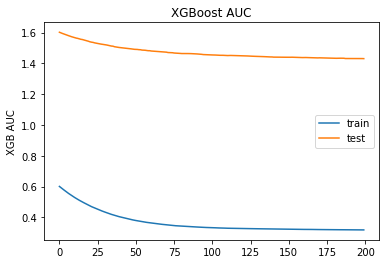

In [46]:
# plot auc wrt estimators
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='train')
ax.plot(x_axis, results['validation_1']['rmse'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

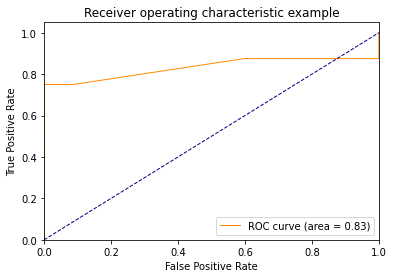

In [47]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(df_test["PREM_FREIGHT_TARGET"].ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, ''),
 Text(140.0, 0, ''),
 Text(160.0, 0, ''),
 Text(180.0, 0, '')]

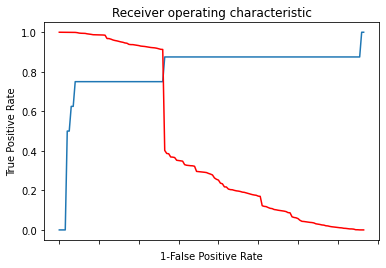

In [48]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [49]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 2.2029366
